This notebook is designed to demonstrate how to produce plots for airborne EM (line data) and induction (point data) on a vertical section. We compare AEM conductvitiy inversions from a 1D-inversion (stored as netcdf file produced using geophys_utils) and 3D-inversions (stored as asci xyx file).

Neil Symington neil.symington@ga.gov.au

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, borehole_utils
import hydrogeol_utils.plotting_utils as plot_utils
import os, glob
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
import netCDF4
import math
import os
import gc
import matplotlib.pyplot as plt

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

def parse_rms_files(lm_file, hm_file, cond_gridded_data = None,
                   interpolate = False):
    
    hm_rms = np.loadtxt(hm_file)

    lm_rms = np.loadtxt(lm_file)
    
    # Dictionary for misfit data
    rms = {}

    # Check that the coordinates are the same

    rms['easting_hm'] = hm_rms[:,0]
    rms['northing_hm'] = hm_rms[:,1]
    rms['easting_lm'] = lm_rms[:,0]
    rms['northing_lm'] = lm_rms[:,1]
    rms['hm_rms'] = hm_rms[:,3]
    rms['lm_rms'] = lm_rms[:,3]
    
    # Reverse if need be
    
    if rms['easting_lm'][0] > rms['easting_lm'][-1]:
        for item in rms:
            rms[item] = rms[item][::-1]
    
    lm_utm = np.column_stack((rms['easting_lm'], rms['northing_lm']))
    hm_utm = np.column_stack((rms['easting_hm'], rms['northing_hm']))
    
    # Calculate the distance along the line 
    
    if interpolate:
        #low moment
        
        cond_utm = np.column_stack((cond_gridded_data['easting'],
                                    cond_gridded_data['easting']))
        
        rms['distance_along_line_lm'] = spatial_functions.interpolate_coordinates(lm_utm,
                                                                                  cond_utm)
                                   
        rms['distance_along_line_hm'] = spatial_functions.interpolate_coordinates(hm_utm,
                                                                                  cond_utm)
                                                                                                                                                      
    else:  
        rms['distance_along_line_lm'] = coords2distance(np.column_stack((rms['easting_lm'],
                                                                     rms['northing_lm'])))
        
        rms['distance_along_line_hm'] = coords2distance(np.column_stack((rms['easting_hm'],
                                                                     rms['northing_hm'])))

        
    return rms

In [3]:
# Function for reading in the misfit files provided by SkyTEM
def parse_misfit_files(lm_file, hm_file):
    
    hm_misfits = np.loadtxt(hm_file)

    lm_misfits = np.loadtxt(lm_file)
    
    # Dictionary for misfit data
    misfits = {}

    # Check that the coordinates are the same

    assert np.unique(hm_misfits[:,:2] == lm_misfits[:,:2])

    misfits['easting'] = hm_misfits[:,0]
    misfits['northing'] = hm_misfits[:,1]
    misfits['distance_along_line'] = coords2distance(hm_misfits[:,:2])
    misfits['hm_misfits'] = hm_misfits[:,2]
    misfits['lm_misfits'] = lm_misfits[:,2]

    # Calculate a normalised data misfit
    n_lmgates = EM_dataset.dimensions['low_moment_gate'].size
    n_hmgates = EM_dataset.dimensions['high_moment_gate'].size
    n_gates = n_lmgates + n_hmgates

    misfits['data_misfits'] = (n_lmgates/n_gates * misfits['lm_misfits']) + (n_hmgates/n_gates * misfits['hm_misfits'])
    
    # Reverse if need be
    
    if misfits['easting'][0] > misfits['easting'][-1]:
        for item in misfits:
            misfits[item] = misfits[item][::-1]
    
    return misfits

In [4]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\OrdBonaparte_nbc_borehole_constrained\delivered_03_12_18\netcdf'

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdBon2019_DataResp_cord2dLogKeep.nc')
ob_dat = netCDF4.Dataset(EM_path)


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdBon2019_ModelExp_cord2dLogKeep.nc')
ob_cond = netCDF4.Dataset(cond_path)


In [5]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\netcdf'

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdKeep2019_DataResp_cor2DLogOrd.nc')
ek_dat = netCDF4.Dataset(EM_path)


# Open the file with the conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
ek_cond = netCDF4.Dataset(cond_path)


In [24]:
# Import data

# Ddefine the header
header = ['easting', 'northing', 'elevation_centre',
          'elevation', 'conductivity']

# Map directory with the CGI AEM data
indir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\delivered\20190617"

# Create an empty dictionary into which the data will be saved
CGI_gridded_data = {}

# If you only want to plot a single file then uncomment this row
#custom_files = ['Keep_L800602_xyzzc.txt']

# Iterate through directories, sub-directories and files
for dirpath, dirnames, filenames in os.walk(indir):
    #for filename in [f for f in filenames if f in custom_files]:
    for filename in [f for f in filenames if f.endswith('_xyzzc.txt')]:
        print(filename)
        # Get the line from the filename
        line= int(filename.split('_')[1][1:])
        
        # Map the absolute path to the file
        file = os.path.join(dirpath, filename)
        
        # Load the gridded column into the dictionary
        #Lex sort file first on easting, then on elevation
        CGI_conductivity = AEM_utils.parse_gridded_conductivity_file(file, header,
                                                                     null=1e-08,
                                                                     lex_sort = True,
                                                                     sort_inds = [3,0])
        ## Griddify based on our knoledge of the structure of the data
        CGI_gridded_data[line] = AEM_utils.griddify_xyz(CGI_conductivity)

# Now bring in the data misfits from a separate file

CGI_rms = {}

for hm_file in glob.glob(indir + '\\*_HM_*'):
    lm_file = hm_file.replace('HM','LM')
    line = int(lm_file.split('\\')[-1].split('_')[0][1:])

    CGI_rms[line] = parse_rms_files(lm_file, hm_file, CGI_gridded_data[line],
                                   interpolate = False)        
        

# Define lines
lines = list(CGI_gridded_data.keys())           

Keep_L315901_unfiltered_xyzzc.txt


In [25]:
CGI_rms

{315901: {'distance_along_line_hm': array([    0.        ,    42.72001873,    84.34705321,   127.12672128,
           171.081812  ,   214.96176186,   258.9150325 ,   303.59578898,
           347.26019096,   389.92586803,   433.61591267,   477.67451001,
           522.50307233,   566.61123484,   608.19981501,   648.79747504,
           691.58637547,   736.49984784,   781.05284998,   825.76313962,
           869.47858312,   911.44833413,   953.27894493,   995.49185765,
          1037.77530595,  1080.70140523,  1124.35240751,  1167.95573307,
          1211.38890012,  1255.29539167,  1298.53484125,  1341.1167623 ,
          1384.37528747,  1428.24896979,  1472.56804017,  1517.10981831,
          1560.06095334,  1601.47713375,  1643.7453251 ,  1687.12608121,
          1730.88199509,  1774.87563099,  1817.53568256,  1859.69276975,
          1902.2627122 ,  1945.77937567,  1988.6415968 ,  2030.77590586,
          2072.96085578,  2115.35106692,  2158.40870271,  2201.92812366,
          2245.14

In [26]:
CGI_rms[line]

{'distance_along_line_hm': array([    0.        ,    42.72001873,    84.34705321,   127.12672128,
          171.081812  ,   214.96176186,   258.9150325 ,   303.59578898,
          347.26019096,   389.92586803,   433.61591267,   477.67451001,
          522.50307233,   566.61123484,   608.19981501,   648.79747504,
          691.58637547,   736.49984784,   781.05284998,   825.76313962,
          869.47858312,   911.44833413,   953.27894493,   995.49185765,
         1037.77530595,  1080.70140523,  1124.35240751,  1167.95573307,
         1211.38890012,  1255.29539167,  1298.53484125,  1341.1167623 ,
         1384.37528747,  1428.24896979,  1472.56804017,  1517.10981831,
         1560.06095334,  1601.47713375,  1643.7453251 ,  1687.12608121,
         1730.88199509,  1774.87563099,  1817.53568256,  1859.69276975,
         1902.2627122 ,  1945.77937567,  1988.6415968 ,  2030.77590586,
         2072.96085578,  2115.35106692,  2158.40870271,  2201.92812366,
         2245.1467539 ,  2288.02903463

In [27]:
# Import data

# Ddefine the header
header = ['easting', 'northing', 'elevation_centre',
          'elevation', 'conductivity']

# Map directory with the CGI AEM data
indir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\delivered\20190411\Keep_L315901_xyzzc"

# Create an empty dictionary into which the data will be saved
CGI_gridded_data_2 = {}

# If you only want to plot a single file then uncomment this row
#custom_files = ['Keep_L800602_xyzzc.txt']

# Iterate through directories, sub-directories and files
for dirpath, dirnames, filenames in os.walk(indir):
    #for filename in [f for f in filenames if f in custom_files]:
    for filename in [f for f in filenames if f.endswith('_xyzzc.txt')]:
        print(filename)
        # Get the line from the filename
        line= int(filename.split('_')[1][1:])
        
        # Map the absolute path to the file
        file = os.path.join(dirpath, filename)
        
        # Load the gridded column into the dictionary
        #Lex sort file first on easting, then on elevation
        CGI_conductivity = AEM_utils.parse_gridded_conductivity_file(file, header,
                                                                     null=1e-08,
                                                                     lex_sort = True,
                                                                     sort_inds = [3,0])
        ## Griddify based on our knoledge of the structure of the data
        CGI_gridded_data_2[line] = AEM_utils.griddify_xyz(CGI_conductivity)

# Now bring in the data misfits from a separate file

CGI_rms_2 = {}

for hm_file in glob.glob(indir + '\\*_HM_*'):
    lm_file = hm_file.replace('HM','LM')
    line = int(lm_file.split('\\')[-1].split('_')[0][1:])

    CGI_rms_2[line] = parse_rms_files(lm_file, hm_file, CGI_gridded_data_2[line],
                                   interpolate = False)            
         
        

Keep_L315901_xyzzc.txt


In [10]:
# Create an instance of plots for gridding the data

plots = plot_utils.ConductivitySectionPlot(ek_cond, ek_dat)
#plots = plot_utils.ConductivitySectionPlot(ob_cond, ob_dat)

# Define some key variables which we want to inteprolate

plots.conductivity_variables = ['conductivity', 'data_residual', 'depth_of_investigation',
                               'easting', 'northing']

plots.EM_varibles  = ['data_values_by_low_moment_gate', 'data_values_by_high_moment_gate', 
                       'data_response_by_low_moment_gate', 'data_response_by_high_moment_gate']


# Define the resolution of th sections
xres, yres = 10., 3.

In [11]:
# Grid the NBC and save it in memory
NBC_gridded_variables = plots.grid_variables(xres = xres, yres =yres, lines=list(lines), smoothed=False,
                                          resampling_method = 'linear', save_hdf5 = False, return_dict = True)

In [12]:
# Now bring in the data misfits from a separate file

CGI_misfits = {}

for hm_file in glob.glob('HM_output*'):
    lm_file = hm_file.replace('HM','LM')
    line = int(lm_file.split('_')[2].split('.')[0][1:])

    CGI_misfits[line] = parse_misfit_files(lm_file, hm_file)



In [13]:
# Bring in the induction data from spatialite database to pandas dataframe

DB_PATH = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\spatialite\East_Kimberley_borehole_data.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

connection = engine.connect()

query = 'SELECT b.* from borehole b;'

df_header = pd.read_sql_query(query, connection)

print(df_header)

    borehole_id Borehole_name Alternative_name     Easting     Northing  \
0        621622       17BP01I             None  478993.383  8335027.204   
1        621623       17BP03I             None  469012.153  8340498.650   
2        621624       17BP04I             None  462705.715  8344019.122   
3        621625       17BP05I             None  461179.050  8347241.926   
4        626981      RN029663             None  509738.000  8297777.000   
5        626984      RN034821             None  514784.000  8313635.000   
6        626986      RN029660             None  500047.884  8295266.378   
7        626987      RN029665             None  512860.000  8302461.000   
8        626988      RN029653             None  514021.000  8301501.000   
9        626989      RN029656             None  504845.000  8293381.000   
10       626990      RN029666             None  518194.000  8307268.000   
11       626991      RN029662             None  500590.000  8288080.000   
12       626992      RN03

In [14]:
# For every bore we will find the distance and netcdf
# index for each borehole that is within 500 m of an AEM fiducial

shape = np.sum(NBC_gridded_variables[item]['easting'].shape[0] for item in NBC_gridded_variables)

aem_coords = np.ones(shape = (shape,2),
                     dtype = NBC_gridded_variables[line]['easting'].dtype)

# Iterate through the AEM lines and get their coordinates into the 2d array

i = 0

for item in enumerate(NBC_gridded_variables):
    
    line_coords = np.hstack((NBC_gridded_variables[line]['easting'].reshape([-1,1]),
                        NBC_gridded_variables[line]['northing'].reshape([-1,1])))
    
    aem_coords[i:i+line_coords.shape[0],:] = line_coords
    
    i += line_coords.shape[0]

# Nearest neighbour query to select the bores

distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']], aem_coords,
                                                        points_required = 1, max_distance = 500.)

In [15]:
# We extract the enos based on a finite value return from our nearest neighbour search
enos = df_header['borehole_id'].values[np.where(np.isfinite(distances))]

# Extract the induction gamma based on the eno

df_induction = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity',
                                                         'borehole_id'], connection, enos,
                                                       verbose = True).dropna()

select t.Depth, t.Apparent_conductivity, t.borehole_id from induction_gamma_data t where t.borehole_id in (626987,626988,635736);


In [16]:
# The induction data is far too dense for plotting so we resample

#Define the depth interval
interval = 1.

# Create an empty dataframe
df_induction_resampled = pd.DataFrame(columns=['borehole_id', 'X', 'Y',
                                               'Depth', 'Apparent_conductivity'])

# ITerate through the bores
for item in df_induction['borehole_id'].unique():
    # Get a mask for the bore we are operating on
    mask= df_induction['borehole_id'] == item

    # define the new depth intervals
    new_depths = np.arange(math.ceil(df_induction[mask]['Depth'].min()),
                           math.floor(df_induction[mask]['Depth'].max()),
                           interval)
    
    # Create an array of resampled depths and values
    df_resampled = spatial_functions.interpolate_depth_data(df_induction[mask],'Apparent_conductivity', 
                                                            'Depth', new_depths = new_depths)
    
    # Now we fill in the other columns with the borehole spatial information and eno
    df_resampled['borehole_id'] = item
    df_resampled['X'] = df_header[df_header['borehole_id'] == item]['Easting'].iloc[0]
    df_resampled['Y'] = df_header[df_header['borehole_id'] == item]['Northing'].iloc[0]
    
    # Append
    df_induction_resampled = df_induction_resampled.append(df_resampled)
    
    

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [17]:
# Define the directory that you want to save the sections to 
outdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\sections_redone'


In [18]:
# Here we the processes below on multiple lines.
# THis can be batched up but we recommend visualising the lines to ensure they are done in the best way possible

line = lines[0]

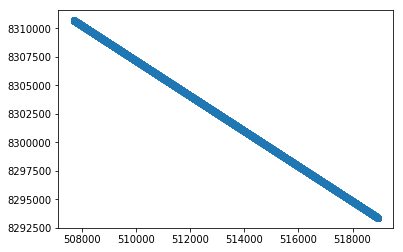

In [20]:
# Out first move is to slice the NBC lines to the range of the 
# CGi lines. This slice can be done with eating and northin and plotting it is 
# the best way to decide what is most appropriate

plt.scatter(CGI_gridded_data_2[line]['easting'],
            CGI_gridded_data_2[line]['northing'])

plt.show()

In [17]:

coord = 'easting'

# Define the min and max coordinate based on the CGI lines
cgi_min= np.min(CGI_gridded_data[line][coord])
cgi_max = np.max(CGI_gridded_data[line][coord])

#Create a mask

mask = np.logical_and(NBC_gridded_variables[line][coord] > cgi_min,
                      NBC_gridded_variables[line][coord] < cgi_max)

# Iterate through the variables

for key in NBC_gridded_variables[line]:
    # Extract data
    a = NBC_gridded_variables[line][key]
    # For 2d arrays
    if len(a.shape) == 2:
        # Slice
        new_a = a[:,mask]
        NBC_gridded_variables[line][key] = new_a
    # For 1d arays
    if len(a.shape) == 1:
        if a.shape == mask.shape: 
            new_a = a[mask]
            NBC_gridded_variables[line][key] = new_a
        else:
            pass

        
# REcalcualte the distance along a line

new_dists =  np.subtract(NBC_gridded_variables[line]['grid_distances'],
                         NBC_gridded_variables[line]['grid_distances'][0])
    
NBC_gridded_variables[line]['grid_distances'] = new_dists

In [21]:
CGI_rms

{315901: {'distance_along_line_hm': array([20511.44713677, 20511.44713677, 20511.44713677, ...,
         20511.44713677, 20511.44713677, 20511.44713677]),
  'distance_along_line_lm': array([20511.29901005, 20511.29901005, 20511.29901005, ...,
         20511.29901005, 20511.29901005, 20511.29901005]),
  'easting_hm': array([507750.3, 507773.3, 507794.2, 507815.5, 507838.1, 507862. ,
         507887.5, 507914.1, 507939.8, 507964.2, 507989.1, 508014.5,
         508040.1, 508063.8, 508085.3, 508105.7, 508127.7, 508151.8,
         508175.7, 508200.2, 508225. , 508248.9, 508272.7, 508296. ,
         508318.5, 508340.6, 508363.6, 508387.3, 508411.3, 508436. ,
         508459.8, 508482.7, 508505.6, 508528.7, 508552. , 508575.4,
         508598.2, 508620.5, 508643.9, 508668.4, 508693.7, 508718.7,
         508741.9, 508764. , 508786.4, 508810.7, 508835.3, 508859.2,
         508882.6, 508905.3, 508928.3, 508952. , 508975.3, 508998.6,
         509021.9, 509046.7, 509072.9, 509099.4, 509125.1, 5091

c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\plotting_utils.py:1254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['min_index'] = i


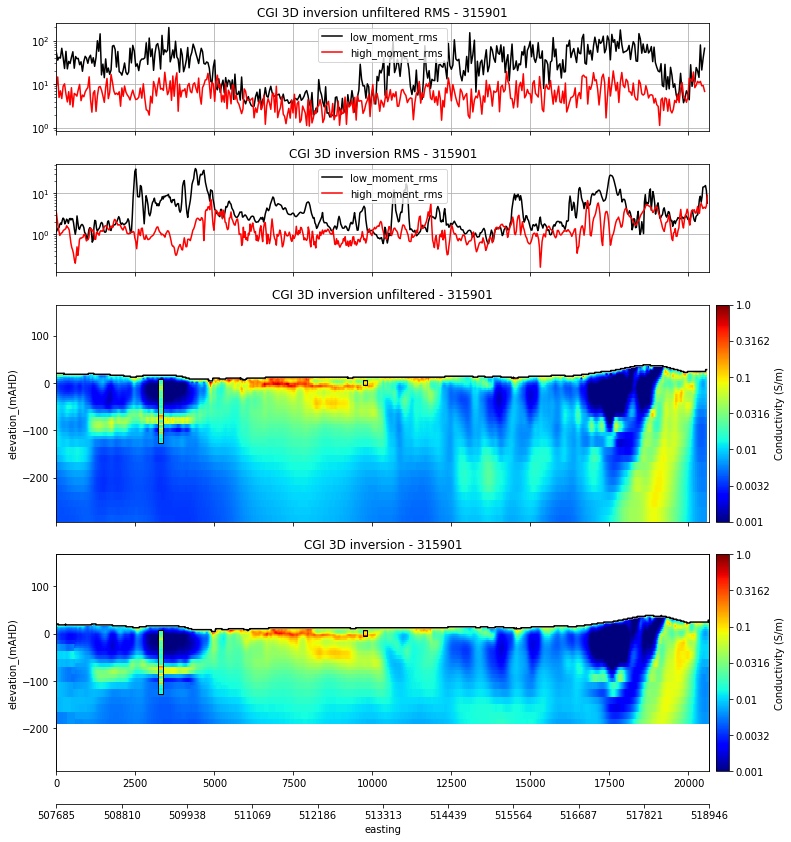

In [44]:
# Panel plotting different CGI inversions

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'Unfiltered residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': True},
                             'height_ratio': 1},
                  'panel_2': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'Filtered residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': True},
                             'height_ratio': 1},
                  'panel_3': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':15.},
                             'height_ratio': 2},
                  
                 'panel_4': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 1,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':15.},
                             'height_ratio': 2}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 1.,
                    'panel_vgap': 2.5, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  height_ratios})


ax_array[0].plot(CGI_rms[line]['distance_along_line_lm'],
                CGI_rms[line]['lm_rms'], 'k', label = 'low_moment_rms')

ax_array[0].plot(CGI_rms[line]['distance_along_line_lm'],
                CGI_rms[line]['hm_rms'], 'red', label = 'high_moment_rms')

ax_array[0].legend()

ax_array[0].set_yscale('log')

ax_array[0].grid()

ax_array[1].plot(CGI_rms_2[line]['distance_along_line_lm'],
                CGI_rms_2[line]['lm_rms'], 'k', label = 'low_moment_rms')

ax_array[1].plot(CGI_rms_2[line]['distance_along_line_hm'],
                CGI_rms_2[line]['hm_rms'], 'red', label = 'high_moment_rms')

ax_array[1].set_yscale('log')

ax_array[1].grid()

ax_array[1].legend()


im1 = plot_utils.plot_grid(ax_array[2], CGI_gridded_data[line], 'conductivity',
                   panel_kwargs[2])


im2 = plot_utils.plot_grid(ax_array[3], CGI_gridded_data_2[line], 'conductivity',
                    panel_kwargs[3])

# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)


for bore in df_induction['borehole_id'].unique():
    
    mask = (df_induction_resampled['borehole_id'] == bore)

   
    for i, ax in enumerate(ax_array[2:]):
        
        cstretch = [panel_kwargs[i+2]['vmin'], panel_kwargs[i+2]['vmax']]
        
        plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask], NBC_gridded_variables[line],
                                         'Apparent_conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=cstretch, log_stretch = True,
                                         stick_thickness=150.)

ax_array[0].set_title("CGI 3D inversion unfiltered RMS - " + str(line))

ax_array[1].set_title("CGI 3D inversion RMS - " + str(line))                                    
                                
ax_array[2].set_title("CGI 3D inversion unfiltered - " + str(line))

ax_array[3].set_title("CGI 3D inversion - " + str(line))



# Add colorbars
plot_utils.add_colourbar(fig, ax_array[2], im1, x0, y0, width, height, panel_kwargs[2])

plot_utils.add_colourbar(fig, ax_array[3], im2, x0, y0, width, height, panel_kwargs[3])


ax_pos = plot_utils.align_axes(ax_array)
# Add axis with northing at the bottom of the plot

#plot_utils.add_axis_coords('northing', NBC_gridded_variables[line]['northing'], ax_array[-1], ax_pos[1], offset=-0.2)

plot_utils.add_axis_coords('easting', NBC_gridded_variables[line]['easting'], ax_array[-1], ax_pos[3], offset=-0.15)

if not os.path.exists(outdir):
    os.makedirs(outdir)

    
outfile = os.path.join(outdir, str(line) + "_filtered_unfiltered_comparison_plot_log.png")

plt.savefig(outfile, dpi=300)

plt.show()

c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\plotting_utils.py:1254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['min_index'] = i


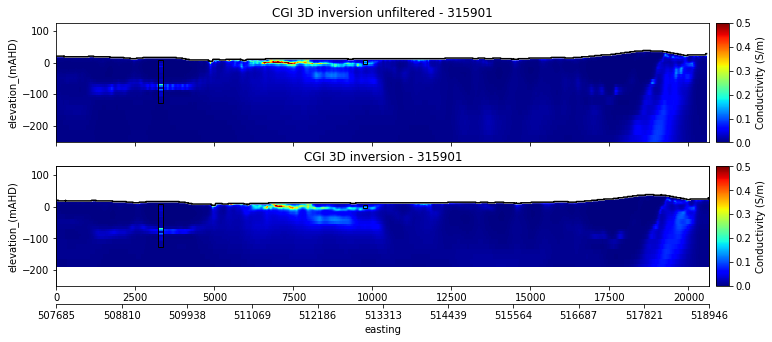

In [44]:
# Panel plotting different CGI inversions

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.5,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':10.},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':10.},
                             'height_ratio': 1}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 1.,
                    'panel_vgap': 1.5, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  height_ratios})
# Axis 1 is NBC

im1 = plot_utils.plot_grid(ax_array[0], CGI_gridded_data[line], 'conductivity',
                   panel_kwargs[0])

# Axis 2 is CGI


im2 = plot_utils.plot_grid(ax_array[1], CGI_gridded_data_2[line], 'conductivity',
                    panel_kwargs[1])

# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)


for bore in df_induction['borehole_id'].unique():
    
    mask = (df_induction_resampled['borehole_id'] == bore)

   
    for i, ax in enumerate(ax_array):
        
        cstretch = [panel_kwargs[i]['vmin'], panel_kwargs[i]['vmax']]
        
        plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask], NBC_gridded_variables[line],
                                         'Apparent_conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=cstretch, log_stretch = False,
                                         stick_thickness=150.)
    
ax_array[0].set_title("CGI 3D inversion unfiltered - " + str(line))

ax_array[1].set_title("CGI 3D inversion - " + str(line))



# Add colorbars
plot_utils.add_colourbar(fig, ax_array[0], im1, x0, y0, width, height, panel_kwargs[0])

plot_utils.add_colourbar(fig, ax_array[1], im2, x0, y0, width, height, panel_kwargs[1])


ax_pos = plot_utils.align_axes(ax_array)
# Add axis with northing at the bottom of the plot

#plot_utils.add_axis_coords('northing', NBC_gridded_variables[line]['northing'], ax_array[-1], ax_pos[1], offset=-0.2)

plot_utils.add_axis_coords('easting', NBC_gridded_variables[line]['easting'], ax_array[-1], ax_pos[1], offset=-0.15)

if not os.path.exists(outdir):
    os.makedirs(outdir)

    
outfile = os.path.join(outdir, str(line) + "_filtered_unfiltered_comparison_plot_linear.png")

plt.savefig(outfile, dpi=300)

plt.show()

c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\plotting_utils.py:1254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['min_index'] = i


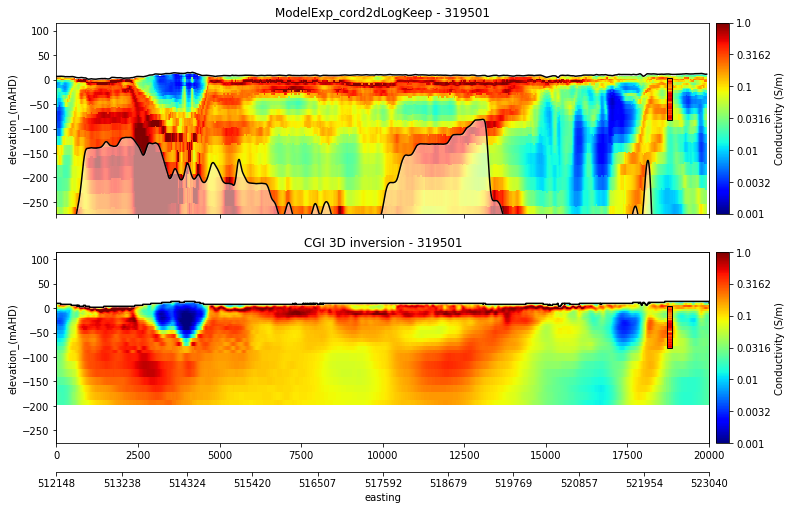

In [19]:

# Plot with linear stretch showing near surface

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':15.},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 1,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':15.},
                             'height_ratio': 1}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 3.,
                    'panel_vgap': 1.5, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,
                                                                                  'height_ratio')})
# Axis 1 is NBC

im1 = plot_utils.plot_grid(ax_array[0], NBC_gridded_variables[line], 'conductivity',
                   panel_kwargs[0])

# Axis 2 is CGI


im2 = plot_utils.plot_grid(ax_array[1], CGI_gridded_data[line], 'conductivity',
                    panel_kwargs[1])

# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)


for bore in df_induction['borehole_id'].unique():
    
    mask = (df_induction_resampled['borehole_id'] == bore)

   
    for i, ax in enumerate(ax_array):
        
        cstretch = [panel_kwargs[i]['vmin'], panel_kwargs[i]['vmax']]
        
        plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask], NBC_gridded_variables[line],
                                         'Apparent_conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=cstretch, log_stretch = True,
                                         stick_thickness=150.)
    
ax_array[0].set_title("ModelExp_cord2dLogKeep - " + str(line))

ax_array[1].set_title("CGI 3D inversion - " + str(line))



# Add colorbars
plot_utils.add_colourbar(fig, ax_array[0], im1, x0, y0, width, height, panel_kwargs[0])

plot_utils.add_colourbar(fig, ax_array[1], im2, x0, y0, width, height, panel_kwargs[1])


ax_pos = plot_utils.align_axes(ax_array)
# Add axis with northing at the bottom of the plot

#plot_utils.add_axis_coords('northing', NBC_gridded_variables[line]['northing'], ax_array[-1], ax_pos[1], offset=-0.2)

plot_utils.add_axis_coords('easting', NBC_gridded_variables[line]['easting'], ax_array[-1], ax_pos[1], offset=-0.15)

if not os.path.exists(outdir):
    os.makedirs(outdir)

    
outfile = os.path.join(outdir, str(line) + "_comparison_plot_log.png")

plt.savefig(outfile, dpi=300)

plt.show()

c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\plotting_utils.py:1254: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['min_index'] = i


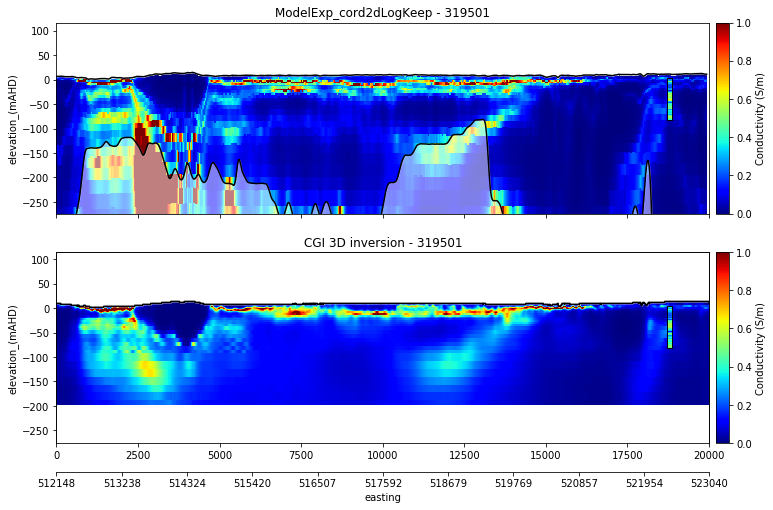

In [41]:


# Plot with linear stretch showing near surface

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 1.,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                                 'vertical_exaggeration':15.},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0., 'vmax': 1.,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':15.},
                             'height_ratio': 1}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 3.,
                    'panel_vgap': 1.5, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,
                                                                                  'height_ratio')})
# Axis 1 is NBC

im1 = plot_utils.plot_grid(ax_array[0], NBC_gridded_variables[line], 'conductivity',
                   panel_kwargs[0])

# Axis 2 is CGI


im2 = plot_utils.plot_grid(ax_array[1], CGI_gridded_data[line], 'conductivity',
                    panel_kwargs[1])

# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)


for bore in df_induction['borehole_id'].unique():
    
    mask = (df_induction_resampled['borehole_id'] == bore)

   
    for i, ax in enumerate(ax_array):
        
        cstretch = [panel_kwargs[i]['vmin'], panel_kwargs[i]['vmax']]
        
        plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask], NBC_gridded_variables[line],
                                         'Apparent_conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=cstretch, log_stretch = panel_kwargs[i]['log_plot'],
                                         stick_thickness=150.)
    
ax_array[0].set_title("ModelExp_cord2dLogKeep - " + str(line))

ax_array[1].set_title("CGI 3D inversion - " + str(line))


# Tight layout
#fig.tight_layout()

# Add colorbars
plot_utils.add_colourbar(fig, ax_array[0], im1, x0, y0, width, height, panel_kwargs[0])

plot_utils.add_colourbar(fig, ax_array[1], im2, x0, y0, width, height, panel_kwargs[1])


ax_pos = plot_utils.align_axes(ax_array)
# Add axis with northing at the bottom of the plot


plot_utils.add_axis_coords('easting', NBC_gridded_variables[line]['easting'], ax_array[-1], ax_pos[1], offset=-0.15)

if not os.path.exists(outdir):
    os.makedirs(outdir)

    
outfile = os.path.join(outdir, str(line) + "_comparison_plot_linear.png")

plt.savefig(outfile, dpi=300)

plt.show()

In [51]:
panel_kwargs

[{'cmap': 'jet',
  'colourbar': True,
  'colourbar_label': 'Conductivity (S/m)',
  'log_plot': False,
  'max_depth': 250,
  'shade_doi': True,
  'title': 'AEM conductivity',
  'vertical_exaggeration': 10.0,
  'vmax': 0.2,
  'vmin': 0.0,
  'ylabel': 'elevation_(mAHD)'},
 {'cmap': 'jet',
  'colourbar': True,
  'colourbar_label': 'Conductivity (S/m)',
  'log_plot': False,
  'max_depth': 250,
  'shade_doi': False,
  'title': 'AEM conductivity',
  'vertical_exaggeration': 10.0,
  'vmax': 0.2,
  'vmin': 0.0,
  'ylabel': 'elevation_(mAHD)'}]

In [6]:
# Import sensitivity

header = ['easting', 'northing', 'elevation_centre',
          'elevation', 'sensitivity']

indir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\delivered\20190528"

CGI_gridded_sensitivity = {}

#custom_files = ['Keep_L800602_xyzzc.txt']

for dirpath, dirnames, filenames in os.walk(indir):
    #for filename in [f for f in filenames if f in custom_files]:
    for filename in [f for f in filenames if f.endswith('sens_HM.txt')]:
        print(filename)
        line= int(filename.split('_')[1][1:])
        file = os.path.join(dirpath, filename)
        
        # Load the gridded column into the dictionary
        CGI_sensitivity = AEM_utils.parse_gridded_conductivity_file(file, header,
                                                                     null=1e-20,
                                                                     lex_sort = True,
                                                                     sort_inds = [3,0])
        ## Griddify
        CGI_gridded_sensitivity[line] = AEM_utils.griddify_xyz(CGI_sensitivity,
                                                              var = 'sensitivity')
        

Bonaparte_L105501_unfilt_sens_HM.txt


c:\users\u77932\documents\github\hydrogeol_utils\hydrogeol_utils\plotting_utils.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['min_index'] = i


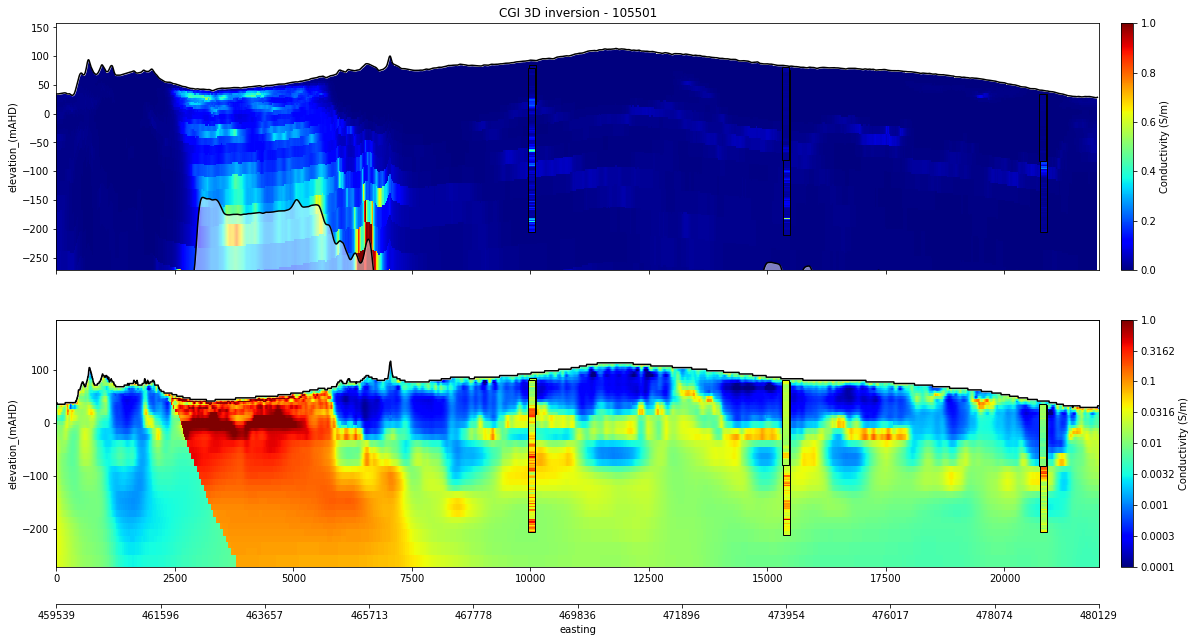

In [24]:
# Plot
panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': False, 'vmin': 0.0, 'vmax': 1.,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1},
                  
                 'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 300, 'shade_doi': False, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.0001, 'vmax': 1,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}


plt.close()

fig, ax_array = plt.subplots(len(panel_settings), 1, figsize=(20, 10), sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,
                                                                                  'height_ratio')})

plot_utils.plot_grid(ax_array[0], gridded_variables[line], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[0])





# We will only plot certain bores


plot_utils.plot_grid(ax_array[1], CGI_gridded_data[line], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[1])



for bore in df_induction['borehole_id'].unique():
    
    mask = (df_induction_resampled['borehole_id'] == bore)

   
    for i, ax in enumerate(ax_array):
        
        
        panel_kwargs = panel_settings['panel_' + str(i + 1)]['panel_kwargs']
        log_stretch = panel_settings['panel_' + str(i + 1)]['panel_kwargs']['log_plot']
        
        cstretch = [panel_kwargs['vmin'], panel_kwargs['vmax']]
        
        plot_utils.add_downhole_log_data(ax, df_induction_resampled[mask], gridded_variables[line],
                                         'Apparent_conductivity', ['X','Y'], cmap='jet',
                                         colour_stretch=cstretch, log_stretch = log_stretch)

     
ax_array[0].set_title("CGI 3D inversion - " + str(line))

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

#plot_utils.add_axis_coords('northing', gridded_variables[line]['northing'],
#                            ax_array[-1], ax_pos[1], offset=-0.2)

plot_utils.add_axis_coords('easting', gridded_variables[line]['easting'],
                           ax_array[-1], ax_pos[1], offset=-0.15)
    

#outfile = os.path.join(outdir, str(line) + "_comparison_plot_linear.png")

#plt.savefig(outfile, dpi=300)

plt.show()

In [11]:
cond =  CGI_gridded_data[line]['conductivity']
log_cond =  np.log10(CGI_gridded_data[line]['conductivity'])
sens = np.log10(CGI_gridded_sensitivity[line]['sensitivity'])

In [12]:
def add_colourbar(fig, ax, im, x0, y0, width, height, log_plot = False,
                 colourbar_label = None):
    
    cm = plt.cm.get_cmap('jet')
    
    # Transform rel position and transform them after to get the 
    # ABSOLUTE POSITION AND DIMENSIONS
    Bbox = mpl.transforms.Bbox.from_bounds(x0, y0, width, height)
    trans = ax.transAxes + fig.transFigure.inverted()
    l, b, w, h = mpl.transforms.TransformedBbox(Bbox, trans).bounds

    # Now just create the axes and the colorbar
    cbaxes = fig.add_axes([l, b, w, h])
    cb = plt.colorbar(im, cax=cbaxes,
                      orientation='vertical')
    # If logplot then transform the labels bac to S/m
    if log_plot:
        cb.ax.set_yticklabels([round(10 ** x, 4) for x in cb.get_ticks()])
    
    if colourbar_label is not None:
        cb.ax.tick_params(labelsize=9)
        cb_label = colourbar_label
        cb.set_label(cb_label, fontsize=10)
        cb.ax.tick_params(labelsize=10)

In [13]:
outdir = r'\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\CGI_OB_3D_AEM_models\sections_sensitivity'



C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


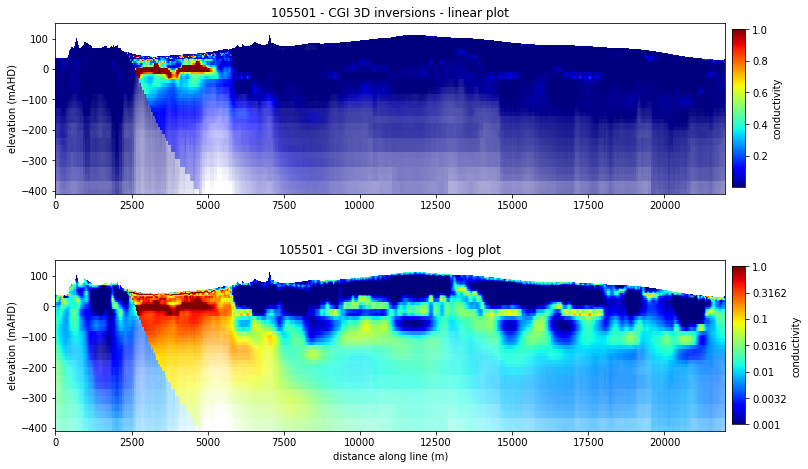

In [14]:
# Use the sensitivity to adjust the alpha of the images
from matplotlib.colors import Normalize
import matplotlib as mpl

outfile = os.path.join(outdir, '105501_sensitivity.png')

plt.close()

alphas = Normalize(-8, -5)(sens)
alphas = np.clip(alphas, 0, 1)


# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow

vmin, vmax = 0.001, 1

cond_rgb = Normalize(vmin, vmax)(cond)

lvmin,lvmax = -3,0

logcond_rgb = Normalize(lvmin,lvmax)(np.log10(cond))


cmap = plt.cm.jet

colors = cmap(cond_rgb)
log_colors = cmap(logcond_rgb)

colors[..., -1] = alphas
log_colors[..., -1] = alphas

fig, (ax1, ax2)  = plt.subplots(2,1,
                                figsize = (12,8))



extent = (CGI_gridded_data[line]['grid_distances'][0], CGI_gridded_data[line]['grid_distances'][-1],
              CGI_gridded_data[line]['grid_elevations'][-1],CGI_gridded_data[line]['grid_elevations'][0])

im1 = ax1.imshow(colors, aspect = 10.,
                cmap = 'jet', extent = extent,
                vmin =vmin, vmax= vmax )

im2 = ax2.imshow(log_colors, aspect = 10.,
                cmap = 'jet', extent = extent,
                vmin =lvmin, vmax= lvmax )

add_colourbar(fig, ax1, im1, 1.01, 0.1, 0.02, 0.8, log_plot = False,
                 colourbar_label = 'conductivity')


add_colourbar(fig, ax2, im2, 1.01, 0.1, 0.02, .8, log_plot = True,
                 colourbar_label = 'conductivity')

ax1.set_title('105501 - CGI 3D inversions - linear plot')
ax2.set_title('105501 - CGI 3D inversions - log plot')

ax1.set_ylabel('elevation (mAHD)')
ax2.set_ylabel('elevation (mAHD)')
ax2.set_xlabel('distance along line (m)')

plt.savefig(outfile, dpi = 250)

plt.show()

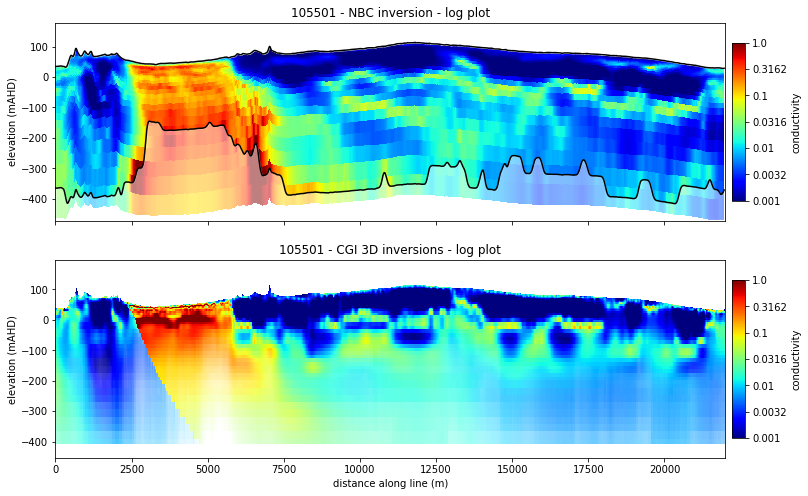

In [22]:
# Use the sensitivity to adjust the alpha of the images
from matplotlib.colors import Normalize
import matplotlib as mpl


panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 500, 'shade_doi': True, 'colourbar': False,
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}


outfile = os.path.join(outdir, '105501_sensitivity_comparison_log.png')

plt.close()

fig, (ax1, ax2)  = plt.subplots(2,1, sharex = True,
                                figsize = (12,8))

extent = (CGI_gridded_data[line]['grid_distances'][0], CGI_gridded_data[line]['grid_distances'][-1],
              CGI_gridded_data[line]['grid_elevations'][-1],CGI_gridded_data[line]['grid_elevations'][0])

im1 = plot_utils.plot_grid(ax1, gridded_variables[line], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[0])

im2 = ax2.imshow(log_colors, aspect = 10.,
                cmap = 'jet', extent = extent,
                vmin =lvmin, vmax= lvmax )

add_colourbar(fig, ax1, im1, 1.01, 0.1, 0.02, 0.8, log_plot = True,
                 colourbar_label = 'conductivity')


add_colourbar(fig, ax2, im2, 1.01, 0.1, 0.02, .8, log_plot = True,
                 colourbar_label = 'conductivity')

ax1.set_title('105501 - NBC inversion - log plot')
ax2.set_title('105501 - CGI 3D inversions - log plot')

ax1.set_ylabel('elevation (mAHD)')
ax2.set_ylabel('elevation (mAHD)')
ax2.set_xlabel('distance along line (m)')

plt.savefig(outfile, dpi = 250)

plt.show()

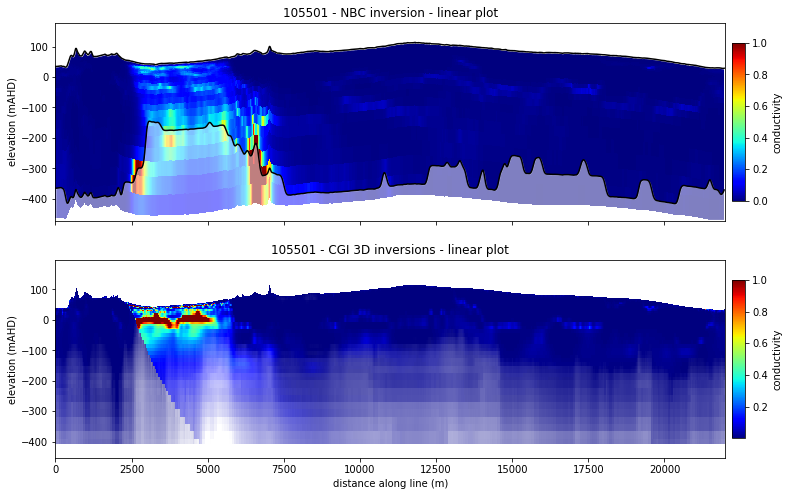

In [23]:
# Use the sensitivity to adjust the alpha of the images
from matplotlib.colors import Normalize
import matplotlib as mpl


panel_settings = {'panel_1': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 500, 'shade_doi': True, 'colourbar': False,
                                             'log_plot': False, 'vmin': 0., 'vmax': 1,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 1}}


outfile = os.path.join(outdir, '105501_sensitivity_comparison_linear.png')

plt.close()

fig, (ax1, ax2)  = plt.subplots(2,1, sharex = True,
                                figsize = (12,8))

extent = (CGI_gridded_data[line]['grid_distances'][0], CGI_gridded_data[line]['grid_distances'][-1],
              CGI_gridded_data[line]['grid_elevations'][-1],CGI_gridded_data[line]['grid_elevations'][0])

im1 = plot_utils.plot_grid(ax1, gridded_variables[line], 'conductivity',
                    plot_utils.unpack_plot_settings(panel_settings, "panel_kwargs")[0])

im2 = ax2.imshow(colors, aspect = 10.,
                cmap = 'jet', extent = extent,
                vmin =vmin, vmax= vmax )

add_colourbar(fig, ax1, im1, 1.01, 0.1, 0.02, 0.8, log_plot = False,
                 colourbar_label = 'conductivity')


add_colourbar(fig, ax2, im2, 1.01, 0.1, 0.02, .8, log_plot = False,
                 colourbar_label = 'conductivity')

ax1.set_title('105501 - NBC inversion - linear plot')
ax2.set_title('105501 - CGI 3D inversions - linear plot')

ax1.set_ylabel('elevation (mAHD)')
ax2.set_ylabel('elevation (mAHD)')
ax2.set_xlabel('distance along line (m)')

plt.savefig(outfile, dpi = 250)

plt.show()